<a href="https://colab.research.google.com/github/mohamed-chamrouk/projet_AIR/blob/master/projet_AIR-Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. IMPORTING LIBRARIES AND DATASET

Let's import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 81kB 3.9MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2021-05-10 10:42:45--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2021-05-10 10:42:45 (87.8 MB/s) - ‘visualization.py’ saved [13008/13008]



Let's get our google drive mount point going

In [2]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + 'colab_netbooks/'

Mounted at /content/gdrive


Now let's get the dataset and read it as a csv

In [7]:
!wget "https://drive.google.com/uc?export=download&id=1BzvT-jeNOSCItKTV95eGsUcKEtm9fn0O"
!mv "uc?export=download&id=1BzvT-jeNOSCItKTV95eGsUcKEtm9fn0O" dataset.csv
df = pd.read_csv('dataset.csv')
df = df.rename(columns={'type':'label'})

--2021-05-10 10:49:41--  https://drive.google.com/uc?export=download&id=1BzvT-jeNOSCItKTV95eGsUcKEtm9fn0O
Resolving drive.google.com (drive.google.com)... 209.85.234.138, 209.85.234.102, 209.85.234.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.234.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oq9952skvatel330g4ut2ii3cqol69k0/1620643725000/15183519386814260962/*/1BzvT-jeNOSCItKTV95eGsUcKEtm9fn0O?e=download [following]
--2021-05-10 10:49:44--  https://doc-0g-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oq9952skvatel330g4ut2ii3cqol69k0/1620643725000/15183519386814260962/*/1BzvT-jeNOSCItKTV95eGsUcKEtm9fn0O?e=download
Resolving doc-0g-34-docs.googleusercontent.com (doc-0g-34-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-0g-34-docs.googleusercontent.com (doc-0

This might get used later on if there are too many labels for the neural network

In [126]:
connection_classes = []
connection_binary = []

for d in df['label'] :
  if d not in ["normal.", "smurf.", "neptune."] :
    connection_classes.append("attack.")
  else :
    connection_classes.append(d)

for d in df['label'] :
  if d != "normal.":
    connection_binary.append("attack.")
  else :
    connection_binary.append(d)

df['connection_classes'] = connection_classes
df['connection_binary'] = connection_binary

encoder = ce.OneHotEncoder(cols=['protocol_type', 'service', 'flag'], use_cat_names=True)
df_encoded = encoder.fit_transform(df)

df_encoded.head(n=50000)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_finger,service_domain_u,service_auth,service_telnet,service_ftp,service_eco_i,service_ntp_u,service_ecr_i,service_other,service_private,service_pop_3,service_ftp_data,service_rje,service_time,service_mtp,service_link,service_remote_job,service_gopher,service_ssh,service_name,service_whois,service_domain,service_login,service_imap4,service_daytime,service_ctf,service_nntp,service_shell,service_IRC,service_nnsp,service_http_443,service_exec,service_printer,service_efs,...,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,connection_classes,connection_binary
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal.,normal.
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal.,normal.
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal.,normal.
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal.,normal.
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal.,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,smurf.,smurf.,attack.
49996,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,smurf.,smurf.,attack.
49997,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,smurf.,smurf.,attack.
49998,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,smurf.,smurf.,attack.


In the following function we'll put everything that's needed to shape our training and testing data for ease of use later on

The first argument is for the features to be trained on, the second the feature that will be predicted and the last one is a bool for balancing the training data

In [113]:
def shape_train(columns, feature, balanced) :
  df_train, df_test = train_test_split(df_encoded,test_size=0.2, random_state=1)

  global X_train
  global X_test
  global y_train
  global y_test
  global X_train_balanced
  global y_train_balanced
  global y_train_balanced_df
  global y_test_df
  global y_train_encoded
  global y_test_encoded
  global sample_size
  global num_of_classes
  global class_names

  X_train = df_train[columns]
  X_test = df_test[columns]

  y_train = df_train[feature]
  y_test = df_test[feature]

  smote = SMOTE()

  if balanced == True :
    try :
      X_train_balanced, y_train_balanced = smote.fit_sample(X_train, y_train)
      y_train_balanced.shape
    except :
      print("Task balacning failed : aborting, keeping the unbalanced features.")

  scaler = MinMaxScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  y_train_balanced_df = pd.DataFrame({feature:y_train})
  y_test_df = pd.DataFrame({feature:y_test})

  one_hot_encoder = ce.OneHotEncoder(cols=[feature], use_cat_names='True')
  one_hot_encoder.fit(y_train_balanced_df)
  y_train_encoded = one_hot_encoder.transform(y_train_balanced_df)
  y_test_encoded  = one_hot_encoder.transform(y_test_df)

  sample_size = X_train.shape[1]

  num_of_classes = y_train_encoded.shape[1]
  class_names = list(y_train_encoded.columns)

# II. NN MODEL

## NN functions

In [14]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model

In [16]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

In [17]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=validation_split )

  return history

## Neural network - binomial

Let's first choose which features we'll train our model with and select the 'connection_binary' feature to be predicted later on

In [146]:
#columns = np.array(df_encoded.columns)
#diff = np.array(['label', 'connection_classes'])
#columns = np.setdiff1d(columns, diff)
columns = ['count', 'dst_bytes', 'src_bytes', 'rerror_rate', 'same_srv_rate', 'land', 'flag_OTH', 'flag_REJ',
       'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1',
       'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH', 'hot', 'is_host_login']
shape_train(columns, 'connection_binary', True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


This will create the model and overwrite any model already saved in memory

In [147]:
shallow_architecture = [8, 6, num_of_classes]
deep_architecture = [8, 8 ,8, 8, 8, 8, 8, 8, 8, num_of_classes]
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 14        
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


Finally let's train our model, save it and load it as `model`

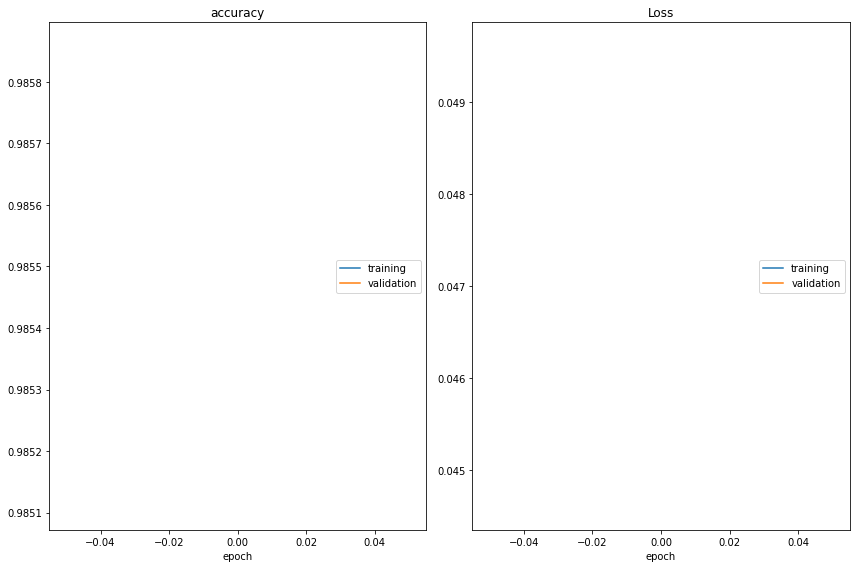

accuracy
	training         	 (min:    0.986, max:    0.986, cur:    0.986)
	validation       	 (min:    0.985, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.050, max:    0.050, cur:    0.050)
	validation       	 (min:    0.045, max:    0.045, cur:    0.045)


In [148]:
nn_file = my_path + 'nn-1attack.h5'

history = train_model(model, nn_file, X_train, y_train_encoded, seed=5, max_epochs=1)

nn_file = my_path + 'nn-1attack.h5'
model = load_model(nn_file)

Which brings us to the following result, which is quite pleasing but nothing that we haven't seen before, the logistic classification was able to do the same, so in the next part we'll see if the model will be able to succeed where the previous model failed

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Normalized confusion matrix
[[9.81216221e-01 1.87837787e-02]
 [5.14747516e-04 9.99485252e-01]]


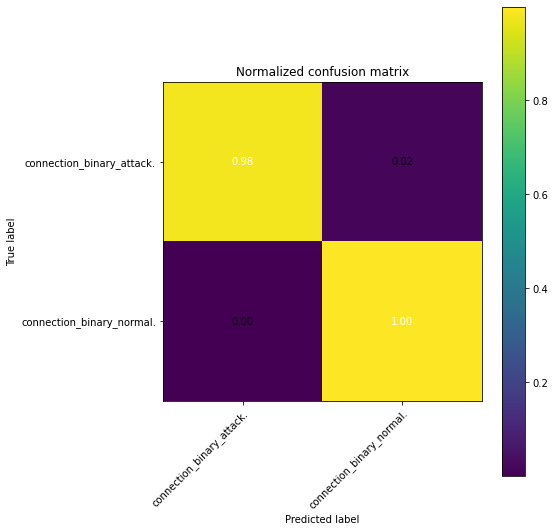

In [149]:
y_proba = model.predict(X_test)
pred_label = model.predict_classes(X_test)
true_label = np.argmax(y_test_encoded.values, axis=1)
plot_conf_mat(true_label, pred_label, np.array(class_names) )

## Neural network - polynomial

We load the training data but select the `connection_classes` this time around which has the top 3 most common attacks of our dataset

In [170]:
columns = ['count', 'num_failed_logins', 'serror_rate', 'dst_bytes']
shape_train(columns, 'connection_classes', True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Let's then reset our model

In [174]:
shallow_architecture = [8, 6, num_of_classes]
model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.1)

And let's train, save and load our new model

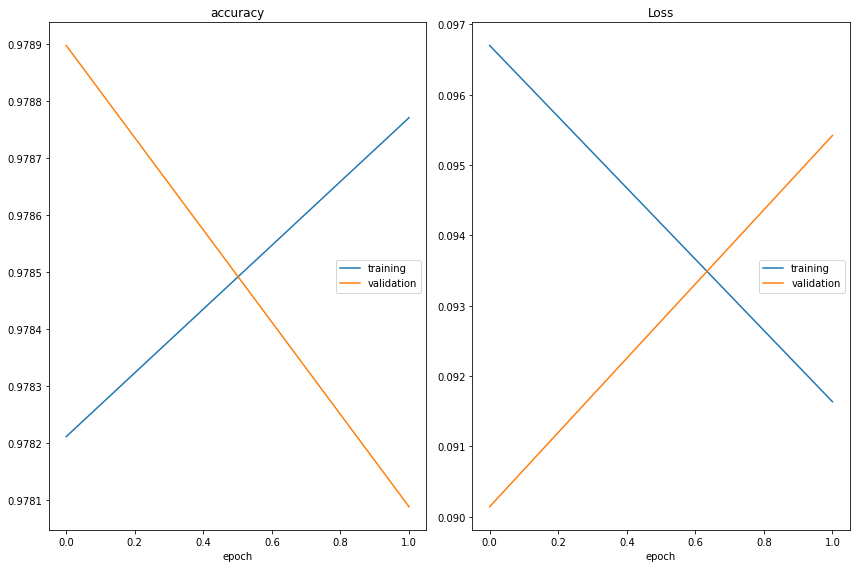

accuracy
	training         	 (min:    0.978, max:    0.979, cur:    0.979)
	validation       	 (min:    0.978, max:    0.979, cur:    0.978)
Loss
	training         	 (min:    0.092, max:    0.097, cur:    0.092)
	validation       	 (min:    0.090, max:    0.095, cur:    0.095)
Epoch 3/200
9875/9881 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9792

KeyboardInterrupt: ignored

In [175]:
nn_file = my_path + 'nn-3attacks.h5'

history = train_model(model, nn_file, X_train, y_train_encoded, seed=5, max_epochs=200)

nn_file = my_path + 'nn-3attacks.h5'
model = load_model(nn_file)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Normalized confusion matrix
[[9.98824619e-01 2.84940875e-04 0.00000000e+00 8.90440234e-04]
 [4.63272765e-04 9.86204767e-01 0.00000000e+00 1.33319607e-02]
 [3.10880829e-02 8.28439839e-01 0.00000000e+00 1.40472078e-01]
 [0.00000000e+00 1.39612807e-04 0.00000000e+00 9.99860387e-01]]


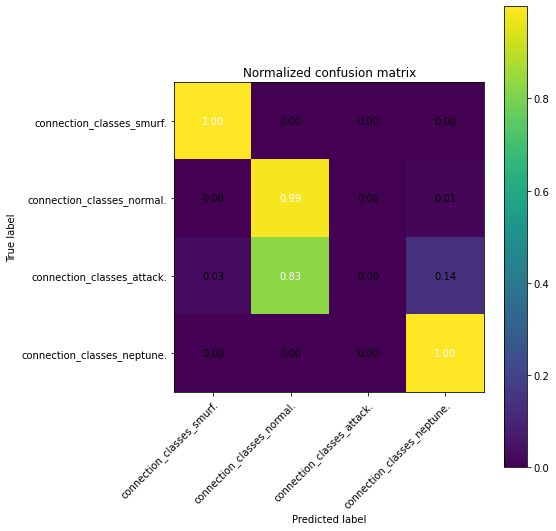

In [173]:
y_proba = model.predict(X_test)
pred_label = model.predict_classes(X_test)
true_label = np.argmax(y_test_encoded.values, axis=1)
plot_conf_mat(true_label, pred_label, np.array(class_names) )